# Train and evaluate Explainers

With all these prerequisites out of the way you can now run the experiments themselves. The experiments are run for each
explanation method (T-GNNExplainer, GreDyCF, CoDy), for each dataset, for each correct/incorrect setting 
(correct predictions only/incorrect predictions only), and for each selection policy (random, temporal, spatio-temporal, 
local-gradient) separately. For convenience, all selection strategies can be automatically evaluated in parallel from a 
single script. An additional feature of the evaluation is that it can be interrupted by Keyboard Interruption or by the
maximum processing time. When the evaluation is interrupted before it is finished, the intermediary results are saved. 
The evaluation automatically resumes from intermediary results.

In [1]:
# Find and add `notebooks/src` to sys.path, no matter where the notebook lives.
from pathlib import Path
import sys, importlib
import os, re
import subprocess
import pandas as pd
from collections import defaultdict
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import numbers

def _add_notebooks_src_to_path():
    here = Path.cwd().resolve()
    for p in [here, *here.parents]:
        candidate = p / "notebooks" / "src"
        if candidate.is_dir():
            if str(candidate) not in sys.path:
                sys.path.insert(0, str(candidate))
            return candidate
    raise FileNotFoundError("Could not find 'notebooks/src' from current working directory.")

print("Using helpers from:", _add_notebooks_src_to_path())

from constants import (
    REPO_ROOT, PKG_DIR, RESOURCES_DIR, PROCESSED_DATA_DIR, MODELS_ROOT, TGN_SUBMODULE_ROOT, ensure_repo_importable, get_last_checkpoint,
    load_notebook_config,
)
ensure_repo_importable()
from device import pick_device
NOTEBOOK_CFG = load_notebook_config()
SEED = int(NOTEBOOK_CFG.get("seed", 42))
DEVICE = pick_device(NOTEBOOK_CFG.get("device", "auto"))
print(f"Notebook config: seed={SEED}, device={DEVICE}")


for p in (str(TGN_SUBMODULE_ROOT), str(REPO_ROOT), str(PKG_DIR)):
    if p not in sys.path:
        sys.path.insert(0, p)

# 2) If your notebook already imported `utils`, remove it to avoid collision
if "utils" in sys.modules:
    del sys.modules["utils"]

importlib.invalidate_caches()

# 4) (Optional) sanity check that TGN's local packages resolve
import importlib.util as iu
print("utils.utils   ->", iu.find_spec("utils.utils"))
print("modules.memory->", iu.find_spec("modules.memory"))

# 5) Now this import should work without the previous error
from time_to_explain.adapters import*

print("REPO_ROOT        :", REPO_ROOT)
print("PKG_DIR          :", PKG_DIR)
print("RESOURCES_DIR    :", RESOURCES_DIR)
print("PROCESSED_DATA_DIR:", PROCESSED_DATA_DIR)
print("MODELS_ROOT      :", MODELS_ROOT)


Using helpers from: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/notebooks/src
Notebook config: seed=42, device=mps
utils.utils   -> None
modules.memory-> ModuleSpec(name='modules.memory', loader=<_frozen_importlib_external.SourceFileLoader object at 0x107e39b10>, origin='/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/submodules/models/tgn/modules/memory.py')
Using REPO_ROOT / ROOT_DIR: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain
Using REPO_ROOT / ROOT_DIR: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain
REPO_ROOT        : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain
PKG_DIR          : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/time_to_explain
RESOURCES_DIR    : /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources
PROCESSED_DATA_DIR: /Users/juliawenkmann/Documents/CodingPr

## Load Dataset and Model

In [2]:
from time_to_explain.utils.graph import NeighborFinder
# Core imports
import torch
from time_to_explain.data import load_explain_idx, load_processed_dataset
from submodules.models.tgat.module import TGAN
from submodules.models.tgn.model.tgn import TGN
from submodules.explainer.tgnnexplainer.tgnnexplainer.xgraph.models.ext.tgn.utils.data_processing import compute_time_statistics

from time_to_explain.core.runner import EvaluationRunner, EvalConfig
from time_to_explain.adapters.tgnnexplainer_adapter import (
    TGNNExplainerAdapter, TGNNExplainerAdapterConfig
)
from time_to_explain.adapters.tg_model_adapter import TemporalGNNModelAdapter
from time_to_explain.extractors.base_extractor import TGEventCandidatesExtractor
import pandas as pd

from time_to_explain.visualization import plot_selected_metrics


ImportError: cannot import name 'TGEventCandidatesExtractor' from 'time_to_explain.extractors.base_extractor' (/Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/time_to_explain/extractors/base_extractor.py)

In [ ]:
MODEL_TYPE = "tgat"
DATASET_NAME = "wikipedia"
TIME_LIMIT = 240
N = 2  # adjust batch size if needed

USE_CACHED_RESULTS = False

def _find_checkpoint(models_root: Path, dataset_name: str, model_name: str) -> Path:
    model_name = model_name.lower()
    dataset_name = str(dataset_name)
    candidates = [
        models_root / dataset_name / model_name / f"{model_name}_{dataset_name}_best.pth",
        models_root / dataset_name / "checkpoints" / f"{model_name}_{dataset_name}_best.pth",
        models_root / "checkpoints" / f"{model_name}_{dataset_name}_best.pth",
    ]
    for cand in candidates:
        if cand.exists():
            return cand
    search_roots = [
        models_root / dataset_name / model_name,
        models_root / dataset_name,
        models_root / "checkpoints",
        models_root / "runs",
    ]
    for root in search_roots:
        if not root.exists():
            continue
        matches = sorted(root.rglob(f"{model_name}*{dataset_name}*.pth"))
        if not matches:
            matches = sorted(root.rglob("*.pth"))
        for match in matches:
            if "best" in match.name:
                return match
        if matches:
            return matches[0]
    raise FileNotFoundError(
        f"Checkpoint not found under {models_root} for {model_name}_{dataset_name}."
    )

ckpt_path = _find_checkpoint(MODELS_ROOT, DATASET_NAME, MODEL_TYPE)
print("Using checkpoint:", ckpt_path)
explain_idx_csv = str(RESOURCES_DIR / "explainer" / "explain_index" / f"{DATASET_NAME}.csv")
print("Explain index CSV:", explain_idx_csv)


mps
Checkpoint: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/models/wikipedia/checkpoints/tgat_wikipedia_best.pth
Explain index CSV: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/explainer/explain_index/wikipedia.csv
Using checkpoint: /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/models/wikipedia/checkpoints/tgat_wikipedia_best.pth


In [ ]:
# Load data
bundle = load_processed_dataset(DATASET_NAME)
events = bundle["interactions"].copy()
edge_feats = bundle.get("edge_features")
node_feats = bundle.get("node_features")
if edge_feats is None or node_feats is None:
    raise ValueError("Missing edge/node features in processed dataset.")
if "e_idx" not in events.columns and "idx" in events.columns:
    events["e_idx"] = events["idx"]


def _build_neighbor_finder(df: pd.DataFrame) -> NeighborFinder:
    u = df["u"].to_numpy(dtype=int)
    v = df["i"].to_numpy(dtype=int)
    ts = df["ts"].to_numpy(dtype=float)
    if "e_idx" in df.columns:
        e_idx = df["e_idx"].to_numpy(dtype=int)
    elif "idx" in df.columns:
        e_idx = df["idx"].to_numpy(dtype=int)
    else:
        e_idx = np.arange(1, len(df) + 1, dtype=int)
    max_node = int(max(u.max(), v.max())) if len(df) else 0
    adj_list = [[] for _ in range(max_node + 1)]
    for src, dst, t, e in zip(u, v, ts, e_idx):
        adj_list[int(src)].append((int(dst), int(e), float(t)))
        adj_list[int(dst)].append((int(src), int(e), float(t)))
    return NeighborFinder(adj_list, uniform=False)



#Dataset: wikipedia, #Users: 8227, #Items: 1000, #Interactions: 157474, #Timestamps: 152757
#node feats shape: (9228, 172), #edge feats shape: (157475, 172)

Backbone ready on mps


/var/folders/k7/xf0yhfbs02ggfm7n1l5g_cnm0000gn/T/ipykernel_62008/1817414911.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_locat

## Train TempME (neural) explainer

This uses the same backbone weights loaded above and trains the TempME explainer on
the preprocessed TempME files (train/test .h5 and _edge.npy).


In [ ]:
from time_to_explain.explainer.tempme_official_runner import (
    TempMEOfficialTrainingConfig,
    train_tempme_official,
)

tempme_ckpt = RESOURCES_DIR / "tempme" / f"{MODEL_TYPE}_{DATASET_NAME}_tempme_ckpt.pt"
tempme_ckpt.parent.mkdir(parents=True, exist_ok=True)

tempme_root = REPO_ROOT / "submodules" / "explainer" / "TempME"
tempme_base_ckpt = tempme_root / "params" / "tgnn" / f"{MODEL_TYPE}_{DATASET_NAME}.pt"

if not tempme_base_ckpt.exists():
    print("TempME base model checkpoint not found at", tempme_base_ckpt)
    print("Train it with submodules/explainer/TempME/learn_base.py for exact matching.")
else:
    cfg = TempMEOfficialTrainingConfig(
        dataset_name=DATASET_NAME,
        base_type=MODEL_TYPE,
        processed_dir=PROCESSED_DATA_DIR,
        tempme_root=tempme_root,
        base_ckpt_path=tempme_base_ckpt,
        output_ckpt=tempme_ckpt,
        device=DEVICE,
        prepare_if_missing=True,
        preprocess_batch_size=1024,
        preprocess_seed=SEED,
    )
    tempme_explainer, saved_ckpt = train_tempme_official(cfg)
    if tempme_explainer is None:
        print("TempME training finished, but no checkpoint was saved.")
    else:
        print("Saved TempME neural checkpoint to", tempme_ckpt)


## Build Extractor and Explainer

In [ ]:
# Extractor creates a stable candidate edge order for each event (needed for fair metrics)
extractor = TGEventCandidatesExtractor(
    model=model,
    events=events,
    threshold_num=50,               # same as your TGNNExplainer config
    keep_order="last-N-then-sort",  # matches TGNNExplainer-TG's pattern
)

# Adapter wraps your existing TGNNExplainer‑TG with the same knobs you use in Hydra
adapter_cfg = TGNNExplainerAdapterConfig(
    model_name=MODEL_TYPE,
    dataset_name=DATASET_NAME,
    explanation_level="event",
    results_dir=str(RESOURCES_DIR / "results"),
    debug_mode=False,
    threshold_num=50,
    save_results=True,
    mcts_saved_dir=str(RESOURCES_DIR / "results" / "tgnnexplainer" / "mcts_saved_dir" ),
    load_results=False,
    rollout=30,
    min_atoms=2,
    c_puct=10.0,
    use_navigator=False,            # set True + navigator_type ("pg"|"mlp"|"dot") if you use a navigator
    navigator_type="pg",
    navigator_params={"train_epochs": 10, "lr": 1e-3, "batch_size": 64, "explainer_ckpt_dir": str(REPO_ROOT / "xgraph" / "explainer_ckpts")},
    cache=True,
)

explainer = TGNNExplainerAdapter(adapter_cfg)


In [ ]:
# Load 1-based event indices you want to explain (same file the Hydra pipeline uses)
target_event_idxs = load_explain_idx(explain_idx_csv, start=0)

# Build anchors (we keep "target_kind" for compatibility; the crucial piece is event_idx)
anchors = [{"target_kind": "edge", "event_idx": int(e)} for e in target_event_idxs[:N]]

sparsity_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

cfg = EvalConfig(
    out_dir="resources/results",
    metrics={
        "sparsity": {},
        "fidelity_minus": {"sparsity": 0.1},
        "fidelity_plus": {"sparsity": 0.1},
        "aufsc": {"sparsity_levels": sparsity_levels, "mode": "minus"},
    },
    seed=SEED,
    resume=USE_CACHED_RESULTS
)

runner = EvaluationRunner(
    model=model,
    dataset={"events": events, "dataset_name": DATASET_NAME},
    extractor=extractor,
    explainers=[explainer],
    config=cfg
)


100 events to explain


## Build Extractor and Explainer

In [ ]:
# Extractor creates a stable candidate edge order for each event (needed for fair metrics)
extractor = TGEventCandidatesExtractor(
    model=model,
    events=events,
    threshold_num=50,               # same as your TGNNExplainer config
    keep_order="last-N-then-sort",  # matches TGNNExplainer-TG's pattern
)

# Adapter wraps your existing TGNNExplainer‑TG with the same knobs you use in Hydra
adapter_cfg = TGNNExplainerAdapterConfig(
    model_name=MODEL_TYPE,
    dataset_name=DATASET_NAME,
    explanation_level="event",
    results_dir=str(RESOURCES_DIR / "results"),
    debug_mode=False,
    threshold_num=50,
    save_results=True,
    mcts_saved_dir=str(RESOURCES_DIR / "results" / "tgnnexplainer" / "mcts_saved_dir" ),
    load_results=False,
    rollout=30,
    min_atoms=2,
    c_puct=10.0,
    use_navigator=False,            # set True + navigator_type ("pg"|"mlp"|"dot") if you use a navigator
    # navigator_type="pg",
    # navigator_params={"train_epochs": 10, "lr": 1e-3, "batch_size": 64, "explainer_ckpt_dir": str(ROOT_DIR / "xgraph" / "explainer_ckpts")},
    cache=True,
)

explainer = TGNNExplainerAdapter(adapter_cfg)


## Run Evaluation

In [ ]:
if USE_CACHED_RESULTS and csv_path.exists():
    print(f"Reusing cached explanations from {csv_path}")
    out = {
        "out_dir": str(out_dir),
        "csv": str(csv_path),
        "jsonl": str(jsonl_path) if jsonl_path.exists() else None,
    }
elif USE_CACHED_RESULTS and jsonl_path.exists():
    print(f"Found cached explanations at {jsonl_path}; computing metrics.")
    out = runner.compute_metrics_from_results(str(jsonl_path), resume=True)
    print(f"Stored metrics under {out['csv']}")
else:
    out = runner.run(
        anchors,
        k_hop=getattr(model, "num_layers", 2) or 2,
        num_neighbors=getattr(model, "num_neighbors", 20) or 20,
        run_id=run_id,
    )
    print(f"Stored new explanations under {out['out_dir']}")
out



explain 0-th: 110314

The nodes in graph is 146


mcts simulating: 100%|██████████| 30/30 [00:16<00:00,  1.81it/s, states=838]


mcts recorder saved at /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/candidate_scores/tgat_wikipedia_110314_mcts_recorder_pg_false_th50.csv
results saved at /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/tgnnexplainer/mcts_saved_dir/tgat_wikipedia_110314_mcts_node_info_pg_false_th50.pt

explain 1-th: 110832

The nodes in graph is 488


mcts simulating: 100%|██████████| 30/30 [00:16<00:00,  1.87it/s, states=838]


mcts recorder saved at /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/candidate_scores/tgat_wikipedia_110832_mcts_recorder_pg_false_th50.csv
results saved at /Users/juliawenkmann/Documents/CodingProjects/master_thesis/time_to_explain/resources/results/tgnnexplainer/mcts_saved_dir/tgat_wikipedia_110832_mcts_node_info_pg_false_th50.pt
Stored new explanations under runs/tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0.20-0.30-0.40-0.50_2anchors


{'out_dir': 'runs/tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0.20-0.30-0.40-0.50_2anchors',
 'jsonl': 'runs/tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0.20-0.30-0.40-0.50_2anchors/results.jsonl',
 'csv': 'runs/tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0.20-0.30-0.40-0.50_2anchors/metrics.csv'}

## Inspect Results and Metrics

Loaded metrics from runs/tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0.20-0.30-0.40-0.50_2anchors/metrics.csv
Rows: 2, Columns: 68


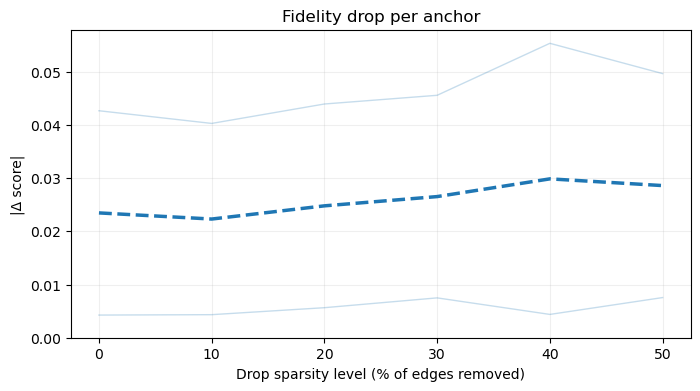

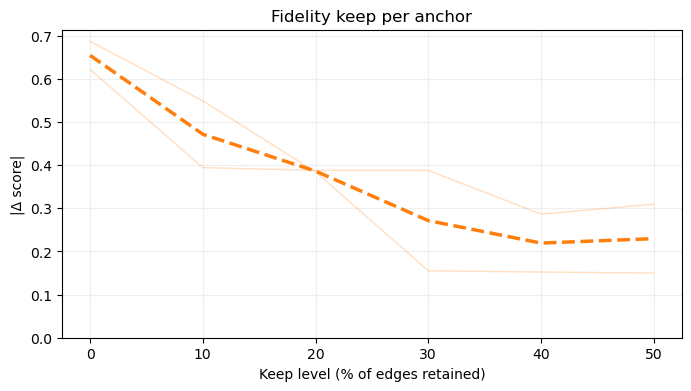

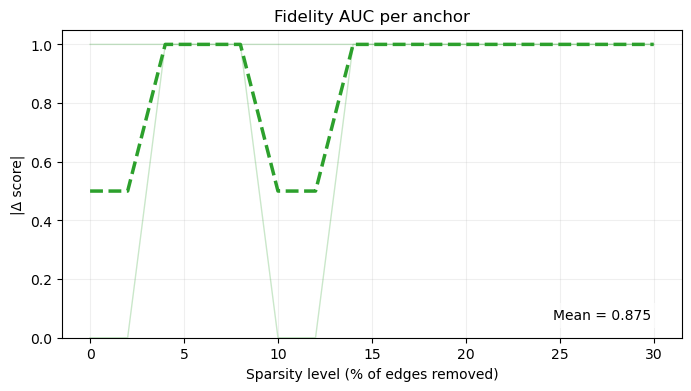

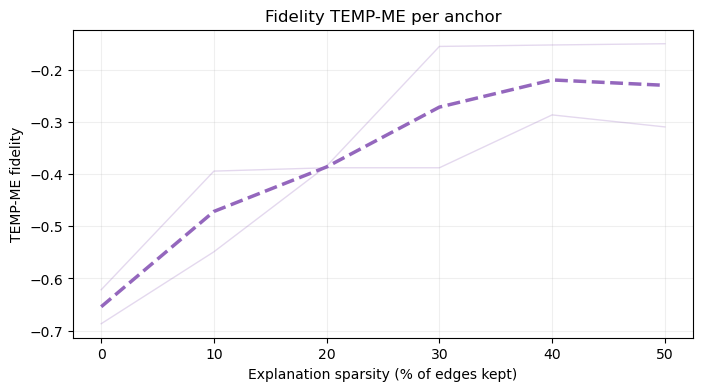

TEMP-ME fidelity: mean=-0.3720, min=-0.6868, max=-0.1498


In [ ]:
metrics_path = out["csv"]
metrics_df = pd.read_csv(metrics_path)
print(f"Loaded metrics from {metrics_path}")
print(f"Rows: {len(metrics_df)}, Columns: {len(metrics_df.columns)}")

context_cols = [c for c in ("anchor_idx", "explainer", "run_id", "elapsed_sec") if c in metrics_df.columns]

METRICS_TO_PLOT = [
    "fidelity_minus.value",
    "fidelity_plus.value",
    "sparsity.ratio",
    "aufsc.value",
    "elapsed_sec",
]

_ = plot_selected_metrics(
    metrics_df,
    METRICS_TO_PLOT,
    group_col="explainer",
)


In [ ]:
metric_groups = defaultdict(list)
for col in metrics_df.columns:
    metric_name, sep, remainder = col.partition('.')
    if not sep:
        continue
    metric_groups[metric_name].append(col)

metric_summary = {}
for metric_name, cols in metric_groups.items():
    metric_cols = [c for c in cols if c in metrics_df.columns]
    if not metric_cols:
        continue
    if context_cols:
        agg = metrics_df.groupby(context_cols, dropna=False)[metric_cols].mean().reset_index()
    else:
        agg = pd.DataFrame({metric_name: metrics_df[metric_cols].mean()}).T
    metric_summary[metric_name] = agg
    
def _parse_suffix(token: str):
    if token.startswith('s='):
        try:
            return float(token.split('=', 1)[1])
        except ValueError:
            return token
    try:
        return float(token)
    except ValueError:
        return token

def column_order(col: str):
    _, _, remainder = col.partition('.')
    if remainder == 'prediction_full':
        return (0, 0, 0)
    if remainder.startswith('prediction_') and '.@' in remainder:
        mode_part, _, suffix = remainder.partition('.@')
        suffix_val = _parse_suffix(suffix)
        mode_rank = {'prediction_drop': 0, 'prediction_keep': 1}.get(mode_part, 2)
        return (1, mode_rank, suffix_val)
    if remainder.startswith('@'):
        suffix_val = _parse_suffix(remainder[1:])
        return (2, 0, suffix_val)
    if remainder == 'best':
        return (3, 0, 0)
    if remainder == 'best.k':
        return (3, 1, 0)
    return (4, remainder, 0)

for metric_name in sorted(metric_groups):
    cols = sorted(set(metric_groups[metric_name]), key=column_order)
    shown = context_cols + [c for c in cols if c in metrics_df.columns]
    if len(shown) <= len(context_cols):
        continue
    print(f"=== {metric_name} ===")
    display(metrics_df[shown].sort_values(by=[c for c in shown if c not in context_cols]))
    summary = metric_summary.get(metric_name)
    if summary is not None and not summary.empty:
        print('Average across groups:')
        summary_cols = [c for c in context_cols if c in summary.columns] + [c for c in cols if c in summary.columns]
        display(summary[summary_cols])


=== acc_auc ===


,anchor_idx,explainer,run_id,elapsed_sec,acc_auc.acc@s=0,acc_auc.acc@s=0.02,acc_auc.acc@s=0.04,acc_auc.acc@s=0.06,acc_auc.acc@s=0.08,acc_auc.acc@s=0.1,...,acc_auc.acc@s=0.14,acc_auc.acc@s=0.16,acc_auc.acc@s=0.18,acc_auc.acc@s=0.2,acc_auc.acc@s=0.22,acc_auc.acc@s=0.24,acc_auc.acc@s=0.26,acc_auc.acc@s=0.28,acc_auc.acc@s=0.3,acc_auc.auc
1,1,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.106411,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.875
0,0,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.788847,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.875


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,acc_auc.acc@s=0,acc_auc.acc@s=0.02,acc_auc.acc@s=0.04,acc_auc.acc@s=0.06,acc_auc.acc@s=0.08,acc_auc.acc@s=0.1,...,acc_auc.acc@s=0.14,acc_auc.acc@s=0.16,acc_auc.acc@s=0.18,acc_auc.acc@s=0.2,acc_auc.acc@s=0.22,acc_auc.acc@s=0.24,acc_auc.acc@s=0.26,acc_auc.acc@s=0.28,acc_auc.acc@s=0.3,acc_auc.auc
0,0,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.788847,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.875
1,1,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.106411,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.875


=== cohesiveness ===


,anchor_idx,explainer,run_id,elapsed_sec,cohesiveness.@s=0.1,cohesiveness.@s=0.2,cohesiveness.@s=0.3,cohesiveness.@s=0.4,cohesiveness.@s=0.5
0,0,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.788847,NaN,NaN,NaN,NaN,NaN
1,1,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.106411,NaN,NaN,NaN,NaN,NaN


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,cohesiveness.@s=0.1,cohesiveness.@s=0.2,cohesiveness.@s=0.3,cohesiveness.@s=0.4,cohesiveness.@s=0.5
0,0,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.788847,NaN,NaN,NaN,NaN,NaN
1,1,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.106411,NaN,NaN,NaN,NaN,NaN


=== fidelity_drop ===


,anchor_idx,explainer,run_id,elapsed_sec,fidelity_drop.prediction_full,fidelity_drop.prediction_drop.@s=0,fidelity_drop.prediction_drop.@s=0.1,fidelity_drop.prediction_drop.@s=0.2,fidelity_drop.prediction_drop.@s=0.3,fidelity_drop.prediction_drop.@s=0.4,fidelity_drop.prediction_drop.@s=0.5,fidelity_drop.@s=0,fidelity_drop.@s=0.1,fidelity_drop.@s=0.2,fidelity_drop.@s=0.3,fidelity_drop.@s=0.4,fidelity_drop.@s=0.5
1,1,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.106411,0.938310,0.980993,0.978608,0.982261,0.983897,0.993673,0.987976,0.042682,0.040298,0.043950,0.045587,0.055362,0.049666
0,0,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.788847,0.986446,0.990706,0.990781,0.992093,0.993939,0.990828,0.993996,0.004260,0.004335,0.005647,0.007493,0.004382,0.007550


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,fidelity_drop.prediction_full,fidelity_drop.prediction_drop.@s=0,fidelity_drop.prediction_drop.@s=0.1,fidelity_drop.prediction_drop.@s=0.2,fidelity_drop.prediction_drop.@s=0.3,fidelity_drop.prediction_drop.@s=0.4,fidelity_drop.prediction_drop.@s=0.5,fidelity_drop.@s=0,fidelity_drop.@s=0.1,fidelity_drop.@s=0.2,fidelity_drop.@s=0.3,fidelity_drop.@s=0.4,fidelity_drop.@s=0.5
0,0,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.788847,0.986446,0.990706,0.990781,0.992093,0.993939,0.990828,0.993996,0.004260,0.004335,0.005647,0.007493,0.004382,0.007550
1,1,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.106411,0.938310,0.980993,0.978608,0.982261,0.983897,0.993673,0.987976,0.042682,0.040298,0.043950,0.045587,0.055362,0.049666


=== fidelity_keep ===


,anchor_idx,explainer,run_id,elapsed_sec,fidelity_keep.prediction_full,fidelity_keep.prediction_keep.@s=0,fidelity_keep.prediction_keep.@s=0.1,fidelity_keep.prediction_keep.@s=0.2,fidelity_keep.prediction_keep.@s=0.3,fidelity_keep.prediction_keep.@s=0.4,fidelity_keep.prediction_keep.@s=0.5,fidelity_keep.@s=0,fidelity_keep.@s=0.1,fidelity_keep.@s=0.2,fidelity_keep.@s=0.3,fidelity_keep.@s=0.4,fidelity_keep.@s=0.5
1,1,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.106411,0.938310,0.316628,0.544172,0.550551,0.550551,0.651950,0.628928,0.621682,0.394138,0.387759,0.387759,0.286360,0.309382
0,0,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.788847,0.986446,0.299625,0.437623,0.602061,0.831419,0.834214,0.836601,0.686821,0.548823,0.384385,0.155027,0.152232,0.149845


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,fidelity_keep.prediction_full,fidelity_keep.prediction_keep.@s=0,fidelity_keep.prediction_keep.@s=0.1,fidelity_keep.prediction_keep.@s=0.2,fidelity_keep.prediction_keep.@s=0.3,fidelity_keep.prediction_keep.@s=0.4,fidelity_keep.prediction_keep.@s=0.5,fidelity_keep.@s=0,fidelity_keep.@s=0.1,fidelity_keep.@s=0.2,fidelity_keep.@s=0.3,fidelity_keep.@s=0.4,fidelity_keep.@s=0.5
0,0,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.788847,0.986446,0.299625,0.437623,0.602061,0.831419,0.834214,0.836601,0.686821,0.548823,0.384385,0.155027,0.152232,0.149845
1,1,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.106411,0.938310,0.316628,0.544172,0.550551,0.550551,0.651950,0.628928,0.621682,0.394138,0.387759,0.387759,0.286360,0.309382


=== fidelity_tempme ===


,anchor_idx,explainer,run_id,elapsed_sec,fidelity_tempme.@s=0,fidelity_tempme.@s=0.1,fidelity_tempme.@s=0.2,fidelity_tempme.@s=0.3,fidelity_tempme.@s=0.4,fidelity_tempme.@s=0.5
0,0,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.788847,-0.686821,-0.548823,-0.384385,-0.155027,-0.152232,-0.149845
1,1,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.106411,-0.621682,-0.394138,-0.387759,-0.387759,-0.286360,-0.309382


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,fidelity_tempme.@s=0,fidelity_tempme.@s=0.1,fidelity_tempme.@s=0.2,fidelity_tempme.@s=0.3,fidelity_tempme.@s=0.4,fidelity_tempme.@s=0.5
0,0,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.788847,-0.686821,-0.548823,-0.384385,-0.155027,-0.152232,-0.149845
1,1,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.106411,-0.621682,-0.394138,-0.387759,-0.387759,-0.286360,-0.309382


=== sparsity ===


,anchor_idx,explainer,run_id,elapsed_sec,sparsity.edges.density,sparsity.edges.entropy,sparsity.edges.gini,sparsity.edges.l0,sparsity.edges.mean,sparsity.edges.n,sparsity.edges.std,sparsity.edges.zero_frac,sparsity.nodes.l0,sparsity.nodes.n
0,0,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.788847,0.04,0.693147,0.94,48,0.04,50,0.195959,0.96,0,0
1,1,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.106411,0.04,0.693147,0.94,48,0.04,50,0.195959,0.96,0,0


Average across groups:


,anchor_idx,explainer,run_id,elapsed_sec,sparsity.edges.density,sparsity.edges.entropy,sparsity.edges.gini,sparsity.edges.l0,sparsity.edges.mean,sparsity.edges.n,sparsity.edges.std,sparsity.edges.zero_frac,sparsity.nodes.l0,sparsity.nodes.n
0,0,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.788847,0.04,0.693147,0.94,48.0,0.04,50.0,0.195959,0.96,0.0,0.0
1,1,tgnnexplainer-tgat,tgat_wikipedia_tgnnexplainer-tgat_s0.00-0.10-0....,16.106411,0.04,0.693147,0.94,48.0,0.04,50.0,0.195959,0.96,0.0,0.0


In [ ]:
if metrics_df.empty:
    raise RuntimeError("metrics_df is empty; nothing to evaluate.")

fidelity_cols = [c for c in metrics_df.columns if c.startswith("fidelity_")]
sparsity_cols = [c for c in metrics_df.columns if "sparsity" in c]

summary = {}

# Fidelity checks
fid_arrays = []
for col in fidelity_cols:
    vals = metrics_df[col].to_numpy(dtype=float)
    finite = vals[np.isfinite(vals)]
    if finite.size == 0:
        raise RuntimeError(f"{col} has no finite values (all NaN/inf).")
    fid_arrays.append(finite)
    frac_nan = 1.0 - (finite.size / max(1, vals.size))
    if frac_nan > 0:
        print(f"⚠️  {col}: {frac_nan:.1%} of values were NaN and were dropped from sanity checks.")

if fid_arrays:
    all_fid = np.concatenate(fid_arrays)
    summary["fidelity"] = {
        "mean": float(all_fid.mean()),
        "std": float(all_fid.std()),
        "min": float(all_fid.min()),
        "max": float(all_fid.max()),
    }
else:
    print("No fidelity_* columns present; skipping fidelity sanity checks.")

# Sparsity checks (should live in [0, 1])
ratio_suffixes = (".zero_frac", ".density")
count_suffixes = (".n", ".l0")

for col in sparsity_cols:
    vals = metrics_df[col].to_numpy(dtype=float)
    finite_mask = np.isfinite(vals)
    finite = vals[finite_mask]
    if finite.size == 0:
        print(f"⚠️  {col}: all values are NaN/inf; skipping.")
        continue
    suffix = next((s for s in ratio_suffixes + count_suffixes if col.endswith(s)), None)
    if suffix in count_suffixes:
        if (finite < -1e-6).any():
            raise RuntimeError(f"{col} contains negative counts: min={finite.min():.3f}")
        summary.setdefault("sparsity_counts", {})[col] = float(finite.mean())
        continue
    if suffix in ratio_suffixes:
        if (finite < -1e-6).any() or (finite > 1 + 1e-6).any():
            raise RuntimeError(
                f"{col} contains values outside [0, 1]: min={finite.min():.3f}, max={finite.max():.3f}"
            )
        summary.setdefault("sparsity", {})[col] = float(finite.mean())
        continue
    summary.setdefault("sparsity_misc", {})[col] = float(finite.mean())
    missing_frac = 1.0 - (finite.size / max(1, vals.size))
    if missing_frac > 0:
        print(f"⚠️  {col}: skipped {missing_frac:.1%} missing values.")

# Monotonicity checks for fidelity series (per row)
trend_expectations = {
    "fidelity_drop": ("non_decreasing", "Removing more edges should not reduce the drop in score."),
    "fidelity_keep": ("non_decreasing", "Keeping more edges should not reduce coverage (expect absolute change grows)."),
}
pattern = re.compile(r"^(fidelity_(?:drop|keep))\.@(.*)")
violations = []

for prefix, (expect, desc) in trend_expectations.items():
    prefix_cols = [c for c in fidelity_cols if c.startswith(prefix + ".@")]
    if not prefix_cols:
        continue
    # sort columns by sparsity level
    col_info = []
    for col in prefix_cols:
        m = pattern.match(col)
        if not m:
            continue
        level = m.group(2)
        try:
            level_val = float(level.split('=')[1]) if level.startswith('s=') else float(level)
        except ValueError:
            continue
        col_info.append((level_val, col))
    col_info.sort()
    if not col_info:
        continue

    for row_idx in metrics_df.index:
        values = []
        for lvl, col in col_info:
            val = metrics_df.at[row_idx, col]
            if val is None:
                continue
            try:
                val_f = float(val)
            except (TypeError, ValueError):
                continue
            if not np.isfinite(val_f):
                continue
            values.append((lvl, val_f))
        if len(values) < 2:
            continue
        values.sort()
        seq = np.array([v for _, v in values], dtype=float)
        diffs = np.diff(seq)
        tol = 1e-6
        if expect == "non_decreasing" and np.any(diffs < -tol):
            violations.append((prefix, row_idx, [lvl for lvl, _ in values], seq.tolist(), desc))

if violations:
    lines = ["Fidelity monotonicity check failed for the following rows:"]
    for prefix, row_idx, lvls, seq, desc in violations[:5]:
        anchor = metrics_df.at[row_idx, "anchor_idx"] if "anchor_idx" in metrics_df.columns else row_idx
        expl = metrics_df.at[row_idx, "explainer"] if "explainer" in metrics_df.columns else "?"
        lines.append(
            f"  [{prefix}] row={row_idx} (anchor={anchor}, explainer={expl}): levels={lvls} values={seq} :: {desc}"
        )
    print("\n".join(lines))


Fidelity monotonicity check failed for the following rows:
  [fidelity_drop] row=0 (anchor=0, explainer=tgnnexplainer-tgat): levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5] values=[0.0042596322010455, 0.0043349189759428, 0.005647166540203, 0.0074926465315692, 0.0043823984291274, 0.0075503470368667] :: Removing more edges should not reduce the drop in score.
  [fidelity_drop] row=1 (anchor=1, explainer=tgnnexplainer-tgat): levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5] values=[0.0426822915737631, 0.0402975653850025, 0.0439502816054006, 0.0455865205239062, 0.05536226985365, 0.0496657003915274] :: Removing more edges should not reduce the drop in score.
  [fidelity_keep] row=0 (anchor=0, explainer=tgnnexplainer-tgat): levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5] values=[0.6868209664725027, 0.5488227114974217, 0.3843846769628624, 0.1550270424189898, 0.1522318144336969, 0.149844905619608] :: Keeping more edges should not reduce coverage (expect absolute change grows).
  [fidelity_keep] row=1 (anchor=1, explainer=tgn

In [ ]:
print("Metric sanity summary:")
for key, val in summary.items():
    print(f"  {key}: {val}")

Metric sanity summary:
  fidelity: {'mean': 0.3610124851761224, 'std': 0.4949080817679168, 'min': -0.6868209664725027, 'max': 0.9939963416009856}
  sparsity_counts: {'sparsity.edges.n': 50.0, 'sparsity.edges.l0': 48.0, 'sparsity.nodes.n': 0.0, 'sparsity.nodes.l0': 0.0}
  sparsity: {'sparsity.edges.zero_frac': 0.96, 'sparsity.edges.density': 0.04}
  sparsity_misc: {'sparsity.edges.gini': 0.94, 'sparsity.edges.entropy': 0.6931471805599453, 'sparsity.edges.mean': 0.04, 'sparsity.edges.std': 0.1959591794226542}
